# Analyzing 9-year NANOGrav data

In this tutorial we will use `enterprise` to analyze the [NANOGrav 9-year data release](https://data.nanograv.org) for a stochastic GW background. We will reproduce the power-law GWB limit from [this paper.](http://adsabs.harvard.edu/cgi-bin/bib_query?arXiv:1508.03024)

In [6]:
% matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext line_profiler

from __future__ import division

import numpy as np
import glob
import matplotlib.pyplot as plt
import scipy.linalg as sl

import enterprise
from enterprise.pulsar import Pulsar
import enterprise.signals.parameter as parameter
from enterprise.signals import utils
from enterprise.signals import signal_base
from enterprise.signals import selections
from enterprise.signals.selections import Selection
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
from enterprise.signals import deterministic_signals

import corner
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

datadir = enterprise.__path__[0] + '/datafiles/ng9/'

### Function to convert PAL2 noise parameters to enterprise parameter dict

In [19]:
def get_noise_from_pal2(noisefile):
    psrname = noisefile.split('/')[-1].split('_noise.txt')[0]
    fin = open(noisefile, 'r')
    lines = fin.readlines()
    params = {}
    for line in lines:
        ln = line.split()
        if 'efac' in line:
            par = 'efac'
            flag = ln[0].split('efac-')[-1]
        elif 'equad' in line:
            par = 'log10_equad'
            flag = ln[0].split('equad-')[-1]
        elif 'jitter_q' in line:
            par = 'log10_ecorr'
            flag = ln[0].split('jitter_q-')[-1]
        elif 'RN-Amplitude' in line:
            par = 'log10_A'
            flag = ''
        elif 'RN-spectral-index' in line:
            par = 'gamma'
            flag = ''
        else:
            break
        if flag:
            name = [psrname, flag, par]
        else:
            name = [psrname, par]
        pname = '_'.join(name)
        params.update({pname: float(ln[1])})
    return params

### Get par, tim, and noise files
Here we collect the tim and par files as well as noise files made from the `PAL2` code. These are the same par, tim, and noise files used in the 9-year analysis papers. We use the convienience function above to convert from `PAL2` noise files to `enterprise` parameter dictionaries.

In [2]:
parfiles = sorted(glob.glob(datadir + '/*.par'))
timfiles = sorted(glob.glob(datadir + '/*.tim'))
noisefiles = sorted(glob.glob(datadir + '/*noise.txt'))

# 18 pulsars used in 9 year analysis
p9 = np.loadtxt(datadir+'/9yr_pulsars.txt', dtype='S42')

# filter
parfiles = [x for x in parfiles if x.split('/')[-1].split('_')[0] in p9]
timfiles = [x for x in timfiles if x.split('/')[-1].split('_')[0] in p9]
noisefiles = [x for x in noisefiles if x.split('/')[-1].split('_')[0] in p9]

### Load into Pulsar class list

In [ ]:
psrs = []
for p, t in zip(parfiles, timfiles):
    psr = Pulsar(p, t, ephem='DE421')
    psrs.append(psr)

### Get parameter dict from noisefiles

In [21]:
params = {}
for nfile in noisefiles:
    params.update(get_noise_from_pal2(nfile))

### Set up model

When setting up the model for our upper limit run we fix all of the white noise (EFAC, EQUAD, and ECORR) parameters to the values obtained from the noise files. This is done by using `Constant` parameters. In this case we do not specify a default value for all instances of that parameter but instead will set them, based on their initialized pulsar and backend specific name, later via the `set_default_params` method of `PTA`. 

Speaking of white noise parameters here, we also use the `Selection` object.

Another feature to notice is that we do not use a uniform prior on the log of the red noise or GWB amplitude. Instead we use a `LinearExp` prior (short for linear-exponent prior), that is a prior of the form $p(x)\propto 10^x$. This is how we can still use the log of the parameter to sample but place a uniform prior on the parameter itself. We do this for both the red noise and GWB amplitude parameters.

Next, in order to save on computing time we do not include spatial correlations here. Instead we model the GWB as a common red process across all pulsars. In `enterprise` we can do this with a simple trick. We pre-initialize the parameters before passing them to the `Signal` model. In this way the *same* parameter instance is used for all pulsars. Lastly, we fixt the spectral index of the GWB to be 13/3 (4.33) using the `Constant` parameter.

In [13]:
# find the maximum time span to set GW frequency sampling
tmin = [p.toas.min() for p in psrs]
tmax = [p.toas.max() for p in psrs]
Tspan = np.max(tmax) - np.min(tmin)

# selection class to break white noise by backend
selection = selections.Selection(selections.by_backend)

##### parameters and priors #####

# white noise parameters
# since we are fixing these to values from the noise file we set
# them as constant parameters
efac = parameter.Constant()
equad = parameter.Constant()
ecorr = parameter.Constant()

# red noise parameters 
log10_A = parameter.LinearExp(-20,-12)
gamma = parameter.Uniform(0,7)

# GW parameters (initialize with names here to use parameters in common across pulsars)
log10_A_gw = parameter.LinearExp(-18,-12)('log10_A_gw')
gamma_gw = parameter.Constant(4.33)('gamma_gw')

##### Set up signals #####

# white noise
ef = white_signals.MeasurementNoise(efac=efac, selection=selection)
eq = white_signals.EquadNoise(log10_equad=equad, selection=selection)
ec = white_signals.EcorrKernelNoise(log10_ecorr=ecorr, selection=selection)

# red noise (powerlaw with 30 frequencies)
pl = utils.powerlaw(log10_A=log10_A, gamma=gamma)
rn = gp_signals.FourierBasisGP(spectrum=pl, components=30, Tspan=Tspan)

# gwb (no spatial correlations)
cpl = utils.powerlaw(log10_A=log10_A_gw, gamma=gamma_gw)
gw = gp_signals.FourierBasisGP(spectrum=cpl, components=30, Tspan=Tspan)

# for spatial correltions you can do...
#orf = utils.hd_orf()
#crn = gp_signals.FourierBasisCommonGP(cpl, orf, components=30, name='gw', Tspan=Tspan)

# timing model
tm = gp_signals.TimingModel()

# to add solar system ephemeris modeling...
#eph = deterministic_signals.PhysicalEphemerisSignal(use_epoch_toas=True)

# full model is sum of components
model = ef + eq + ec + rn + tm + gw

# intialize PTA
pta = signal_base.PTA([model(psr) for psr in psrs])

### Set white noise parameters

In [ ]:
pta.set_default_params(params)

### Set initial parameters drawn from prior and evaluate likelihood to fill caches

Evaluating the likelihood is not necessary, the caches will be filled the first time it is called within the sampler if not called here.

In [23]:
xs = {par.name: par.sample() for par in pta.params}
print pta.get_lnlikelihood(xs);
print pta.get_lnprior(xs);

1396202.32558
-32.2501201076


### Set up sampler

In [24]:
# dimension of parameter space
ndim = len(xs)

# initial jump covariance matrix
cov = np.diag(np.ones(ndim) * 0.01**2)

# set up jump groups by red noise groups 
ndim = len(xs)
groups  = [range(0, ndim)]
groups.extend(map(list, zip(range(0,ndim,2), range(1,ndim,2))))
groups.extend([[36]])

sampler = ptmcmc(ndim, pta.get_lnlikelihood, pta.get_lnprior, cov, groups=groups, 
                 outDir='chains/nano_9_gwb/')

### Sample!

In [ ]:
# sampler for N steps
N = 1000000
x0 = np.hstack(p.sample() for p in pta.params)
sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50, )

### Plot output

In [33]:
chain = np.loadtxt('chains/nano_9_gwb/chain_1.txt)
pars = sorted(xs.keys())
burn = int(0.25 * chain.shape[0])

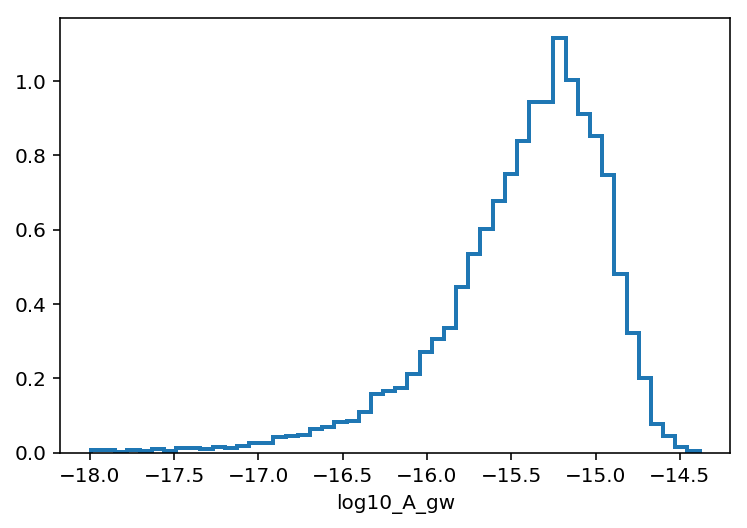

In [34]:
plt.hist(chain[burn:,-5], 50, normed=True, histtype='step', lw=2);
plt.xlabel(pars[-1]);

### Upper limit value

We see that the upper limit agrees perfectly with the published value.

In [39]:
upper = 10**np.percentile(chain[burn:, -5], q=0.95)
print(upper)

1.49899289556e-15
